## Spam Classification
In this notebook we demonstrate how to classify if an image is SPAM or HAM using the SMS Spam Collection Dataset which can be found [here](https://www.kaggle.com/uciml/sms-spam-collection-dataset#spam.csv)


In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2020-05-09 23:16:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   361KB/s    in 0.5s    

2020-05-09 23:16:43 (361 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [0]:
import pandas as pd

In [0]:
df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

ham     0.865937
spam    0.134063
Name: target, dtype: float64

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_train, df_test = train_test_split(df,stratify = df['target'], test_size = 0.2, random_state = 2020)

In [0]:
df_train.shape,df_test.shape

((4457, 2), (1115, 2))

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_test, path = "")

# Classifier model data
data_class = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

TextLMDataBunch applies some text preprocessing tasks to help the algorithm perform better. Altough we commonly remove stoopwords and punctuations, here we do not do it. This model can handle semantics, deleting such information might do more harm than good with respect to accuracy

Now lets look at our training data


In [0]:
data_lm.show_batch()

idx,text
0,". xxmaj mark is taking forever to pick up my prescription and the pain is coming back . xxbos xxmaj your credits have been xxunk up for http : / / xxunk xxmaj your renewal xxmaj pin is xxunk xxbos xxmaj loan for any purpose £ 500 - £ 75,000 . xxmaj homeowners + xxmaj tenants welcome . xxmaj have you been previously refused ? xxmaj we can still help"
1,"b going to esplanade fr home ? xxbos somewhere out there beneath the pale moon light someone think in of u some where out there where dreams come true ... goodnite & & sweet dreams xxbos xxmaj well that must be a pain to catch xxbos sry ca n't talk on phone , with parents xxbos xxmaj hope you are having a good week . xxmaj just checking in xxbos"
2,"on a xxup reality xxup fantasy xxup show call now = 08707509020 xxmaj just 20p per min xxup ntt xxmaj ltd , xxup po xxmaj box 1327 xxmaj croydon xxup cr9 xxup 5wb 0870 is a national = rate call xxbos i think your xxunk is , but not 100 xxunk sure . xxbos xxmaj all e best 4 ur driving tmr :-) xxbos xxmaj finished class where are you"
3,"is * rite u put xxunk 10 xxunk mnth is that all ? xxbos xxmaj have you been xxunk your xxunk ? xxbos xxmaj what year . xxmaj and how many miles . xxbos , how 's things ? xxmaj just a quick question . xxbos xxmaj tell your friends what you plan to do on xxmaj valentines day @ < xxup url > xxbos * xxmaj was really good"
4,message . xxmaj this is a final contact attempt . xxmaj you have important messages waiting out our customer claims xxunk . xxmaj expires 13 / 4 / 04 . xxmaj call xxunk xxup now ! xxbos xxmaj miles and smiles r made frm same letters but do u know d difference .. ? smile on ur face keeps me happy even though i am miles away from u ..


Those 'xxmaj','xxbos', 'xxup' etc are all special tokens for the NN. xxbos stands for begin of sentence, xxmaj indicates that the first letter of the next word is in capital letter, 'xxup' is used to indicate the entire  next word is in captital letters. You can view the entire set of tokens [here.](https://docs.fast.ai/text.transform.html)

In [0]:
model = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.5)

We will use a pretrained model. You can learn more about it [here.](https://docs.fast.ai/text.models.html#Language-model-modules)

Now lets test our language model. Its is giving sensible outputs as it is pre trained on wiki corpus. 


In [0]:
for i in range(10):
  print(model.predict("The food is", n_words=15))

The food is made from red and white , with white of the same color as the red
The food is made from the leaves of the ground - meal floor , made of cooking sticky
The food is used as an food source in South Another Day , during the
The food is a well - - liked and un - used to the press of the day
The food is from the English Middle Ages and is used as an orchard to
The food is fair and expensive , it is very expensive , simply to sell it .
The food is weather well , the food is poor or strong enough to have good food and
The food is a British Special Class Quality Quality Rate by the
The food is made from food , including rice and beer . There is a food table
The food is high - quality in many of Europe but Europe , and is


We will now need to fine tune our model for our particular task. <br>

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 6.31E-02


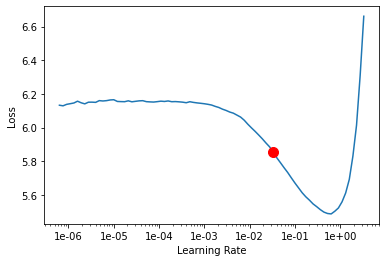

In [0]:
model.lr_find() # you can find more details about this at https://docs.fast.ai/basic_train.html
model.recorder.plot(suggestion=True)

In [0]:
model.fit_one_cycle(1, max_lr= 5e-02)#you can freeze and unfreeze different layers and by doing so we can have different lr for each layer
#for freezing and unfreezing code you can refer https://docs.fast.ai/text.html


epoch,train_loss,valid_loss,accuracy,time
0,5.272813,4.241411,0.245015,02:19
1,4.494938,3.909058,0.283110,02:19
2,3.977000,3.777759,0.301265,02:19
3,3.581248,3.738363,0.307403,02:19


In [0]:
for i in range(10):
  print(model.predict("The food is", n_words=15))

The food is easy and easy , the original and egg is : ) If u
The food is have been paid , text text SUBPOLY to nit . Dear Midnight
The food is done at full price .. n it is free . Hey , who is
The food is done as planned . It is safe but its safe and Hospital will
The food is malaria . Its malaria , but its malaria and Malaria is malaria !
The food is done in sweet dreams and someone Japanese Proverb conducts to use every egg
The food is stylish rite , and the food is daily . The egg is safe and
The food is sent direct to and from connections from taxi 4 next wednesday . The food
The food is that in computer 2day remains : ) xxbos How . i called it can
The food is a constant , is d energy mind face , and has one foot and a


Note that now the model is predicting ':)' and other such characters which can generally be seen in SMS messages. With further more fine tuning and running it for more cyles you can get the model to predict more characters which are found in SMS messages.